In [1]:
# IMPORTING LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

In [2]:
# INPUT INFORMATION

#Information for share and option
t = 1        #maturity of option
s0 = 100     #Current share price
r = 0.08     #Risk free continuously compounded interest rate
sigma = 0.3  #Volatility of share
k = 100      #Strick price since it's given that the option is struck at-the-money
L_given = 150      #Up & Out barrier for the option
L = L_given/np.exp(0.5826 * sigma * np.sqrt(t/12)) # adjustment to barrier to deal with discrete barrier monitoring

#Information for firm
sigma_firm = 0.25 #Volatility of firm
debt = 175        #Value of debt on firm, due in 1 year
corr = 0.2        #correlation between the counterparty and the stock
rr = 0.25         #Recovery rate with the counterparty
v0 = 200          #Assuming firm current value to be $200

In [3]:
# FUNCTION DEFINITIONS - FOR MONTE CARLO ESTIMATION

# Function to generate path of share prices and firm values
def share_path(S_0, R, sigma, Z, dT):
    # S_0 = initial value, R = risk-free rate, sigma = volatility,
    # Z = series of standard normal random variables, dT = increments of time at which values are to be calculated
    return S_0*np.exp(np.cumsum((R - sigma**2/2)*dT + sigma*np.sqrt(dT)*Z))

#Function for discounted payoff/price  of a European up and out call option
#logic used is Payoff becomes 0 if the share price crosses barrier L
def upandout_call_payoff_disc (S1, K, L, R, T):
    #S1 = share price path over life of the option, because barrier option is path dependent
    # K = strike, L = barrier, R = risk-free rate, T = maturity of option
    if max(S1) < L: # if barrier is not crossed during life of the option, payoff is same as that of a regular European call option
        return np.exp(-R*T)*np.maximum((S1[-1]-K),0) # S1[-1] is the terminal stock price
    else: # if barrier is crossed any time during life of the option, payoff becomes 0
        return 0

In [4]:
# Pre-allocating space for monthly share prices, firm values, option payoffs, and amounts lost
share_prices = [np.empty([i*1000,12]) for i in range(1,51)] # "empty" list of 50 numpy matrices - one for each sample size
firm_values  = [np.empty([i*1000,12]) for i in range(1,51)] # "empty" list of 50 numpy matrices - one for each sample size
option_payoffs = [[None]*i*1000 for i in range(1,51)] # list of None lists - one for each sample size
losses = [[None]*i*1000 for i in range(1,51)] # list of None arrays - one for each sample size
# It may be noted that option_payoffs and losses have been created as a list of lists (instead of matrix) because each sub-list is of a different length

corr_matrix = np.array([[1,corr],[corr,1]]) #Creating correlation matrix from given correlation between share and firm


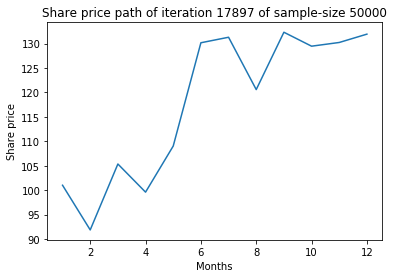

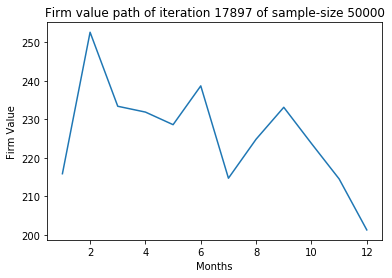

In [5]:
"ANSWER 1: MONTHLY SIMULATIONS OF FIRM VALUE AND SHARE PRICE FOR LIFETIME OF THE OPTION - SAMPLE SIZES OF 1000, 2000, ..., 50000"

dT = t/12 # we need to do monthly simulations over the option life of 1 year. So, each price on the path will be generated at increments of (1/12) years

for i in range(1,51): # Looping over samples of different sizes - 1000 to 50000
    
    for j in range(i*1000): # Iterating <sample-size> number of times
        
        # Generating correlated monthly random values for firm and stock over 1 year
        norm_matrix = norm.rvs(size = np.array([2,12]))  # Uncorrelated standard normal random variables - 2 assets (stock and firm) - 12 months
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix) # Correlated standard normal random variables using Cholesky decomposition
    
        # Generating path of monthly share prices and firm values over 1 year
        # Storing them in the numpy matrics created above
        share_prices[i-1][j] = share_path(s0, r, sigma, corr_norm_matrix[0,], dT) # Path of monthly share prices over 1 year
        firm_values[i-1][j] = share_path(v0, r, sigma_firm, corr_norm_matrix[1,], dT) # Path of monthly firm values over 1 year
        
        # Calculating option payoff for each price path, and the corresponding amount lost
        # Storing them in the None lists created above
        option_payoffs[i-1][j] = upandout_call_payoff_disc(share_prices[i-1][j],k,L,r,t) # Discounted payoff of option
        losses[i-1][j] = (1-rr)*option_payoffs[i-1][j]*(firm_values[i-1][j][-1] < debt) # Loss if counterparty firm defaults (assumption: default can occur only at maturity)
        # it may be noted that since the call option payoff is discounted, we have removed the discounting term from the formula of amount_lost

# Plotting any one (randomly) of the samples of share prices and firm values simulated
        
sample = random.randint(1,50)
row_of_sample = random.randint(0,sample*1000-1)   
     
plt.plot(range(1,13),share_prices[sample-1][row_of_sample])
plt.ylabel("Share price")
plt.xlabel("Months") 
plt.title("Share price path of iteration %d of sample-size %d"%(row_of_sample, sample*1000))
plt.show()

plt.plot(range(1,13),firm_values[sample-1][row_of_sample])
plt.ylabel("Firm Value")
plt.xlabel("Months") 
plt.title("Firm value path of iteration %d of sample-size %d"%(row_of_sample, sample*1000))
plt.show()


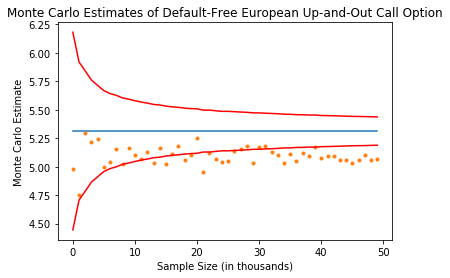

In [6]:
"ANSWER 2 (a): MONTE CARLO ESTIMATION OF DEFAULT-FREE VALUE OF OPTION"

# Calculating means and std devs of option payoffs for the different samples    
option_price_estimates = [np.mean(option_payoffs[i-1]) for i in range(1,51)] # Mean values of option's payoff from samples 
option_price_stdevs = [np.std(option_payoffs[i-1])/np.sqrt(i*1000) for i in range(1,51)] # Standard Deviation of option's payoff from samples 

# Calculating analytical price of option
# Price of up-and-out European call option = Cbs(s0,k) - Cbs(s0,L) - (L-k)e^(-rt)*phi(dBS(s0,L))
#                                            - (L/s0)^(2v/sigma^2) { Cbs(L^2/s0,k) - Cbs(L^2/s0,L) - (L-k)e^(-rt)*phi(dBS(L,s0)}
# where Cbs(s0,K) = price of vanilla European call option with initial stock price s0 and strike price k
#       dBS = (ln(s0/k)+v*sqrt(t))/(sigma*sqrt(T))
#       v = r - (sigma^2/2)

L = L_given # For analytical price calculation, we just use the barrier given, not the adjusted barrier

def analytical_callprice(S_0, strike, risk_free, sigma, T, current_time):
    # This function calculates analytical price of a vanilla European call option
    # It will be used to calculate analytical price of up-and-out call option
    # S_0 = Initial stock price, strike = strike price, risk_free = risk-free rate
    # sigma = volatility of stock price, T = maturity of option, current_time = time of option price calculation
    d1 = (np.log(S_0/strike)+(risk_free+sigma**2/2)*(T-current_time))/(sigma*np.sqrt(T-current_time))
    d2 = d1 - sigma*np.sqrt(T-current_time)
    return S_0*norm.cdf(d1) - strike*np.exp(-risk_free*(T-current_time))*norm.cdf(d2) 

def dBS(S_0, strike, risk_free, sigma, T, current_time):
    # This function calculates d(BS)
    # It will be used to calculate analytical price of up-and-out call option
    # S_0 = Initial stock price, strike = strike price, risk_free = risk-free rate
    # sigma = volatility of stock price, T = maturity of option, current_time = time of option price calculation
    v = risk_free-(sigma**2/2)
    return (np.log(S_0/strike) + v*(T-current_time))/(sigma*np.sqrt(T-current_time))

# Intermediate calculations:
term_1 = analytical_callprice(s0,k,r,sigma,t,0)
term_2 = analytical_callprice(s0,L,r,sigma,t,0)
term_3 = (L-k)*np.exp(-r*t)*norm.cdf(dBS(s0,L,r,sigma,t,0))
term_4 = analytical_callprice((L**2/s0),k,r,sigma,t,0)
term_5 = analytical_callprice((L**2/s0),L,r,sigma,t,0)
term_6 = (L-k)*np.exp(-r*t)*norm.cdf(dBS(L,s0,r,sigma,t,0))
v = r-(sigma**2/2)
factor = (L/s0)**((2*v)/sigma**2)

# Finally, calculating analytical price of option
upandout_analytical_price = term_1 - term_2 - term_3 - factor*(term_4 - term_5 - term_6)

# Plotting estimates against analytical option price for increasing sample size
plt.plot([upandout_analytical_price]*50) # plotting analytical price as a line
plt.plot(option_price_estimates,'.') # plotting estimates as points
# plotting upper and lower error bound at 3 std. devs. from analytical put price as red lines
plt.plot(upandout_analytical_price + np.array(option_price_stdevs)*3, 'r') 
plt.plot(upandout_analytical_price - np.array(option_price_stdevs)*3, 'r')
# setting x and y labels, and title for the plot
plt.xlabel("Sample Size (in thousands)")
plt.ylabel("Monte Carlo Estimate")
plt.title("Monte Carlo Estimates of Default-Free European Up-and-Out Call Option")
plt.show() # displaying the plot

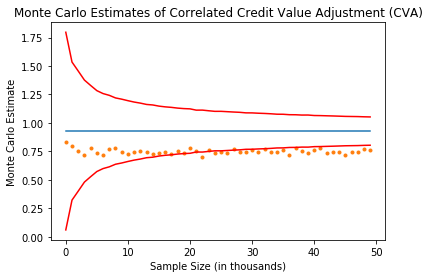

In [7]:
"ANSWER 2 (b): MONTE CARLO ESTIMATION OF CVA"

# Calculating means and std devs of cva estimates for the different samples
cva_estimates = [np.mean(losses[i-1]) for i in range(1,51)] # Mean values of loss in price/value 
cva_stdevs = [np.std(option_payoffs[i-1])/np.sqrt(i*1000) for i in range(1,51)] # Standard Deviation of loss in price/value 

# Calculating analytical uncorrelated CVA (to be used as baseline in plot)
# Uncorrelated CVA = (1 - recovery rate) * price of asset * phi(-d2)
# phi(-d2) is the default_prob calculated below, and price of asset is the analytical option price calculated above

# Calculating probability of default of firm given by phi(-d2)
d_1 = (np.log(v0/debt)+(r + sigma_firm**2/2)*t)/(sigma_firm*np.sqrt(t))
d_2 = d_1 - sigma_firm*np.sqrt(t)
default_prob = norm.cdf(-d_2)

# Finally, calculating analytical CVA when correlation is 0
uncorr_cva = (1-rr)*default_prob*upandout_analytical_price

# Plotting estimates against analytical CVA for increasing sample size
plt.plot([uncorr_cva]*50) # plotting analytical uncorrelated cva as a line
plt.plot(cva_estimates,'.') # plotting estimates as points
# plotting upper and lower error bound at 3 std. devs. from analytical cva as red lines
plt.plot(uncorr_cva + np.array(cva_stdevs)*3, 'r') 
plt.plot(uncorr_cva - np.array(cva_stdevs)*3, 'r')
# setting x and y labels, and title for the plot
plt.xlabel("Sample Size (in thousands)")
plt.ylabel("Monte Carlo Estimate")
plt.title("Monte Carlo Estimates of Correlated Credit Value Adjustment (CVA)")
plt.show() # displaying the plot


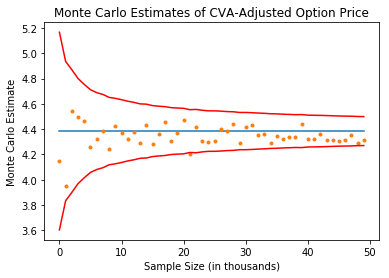

In [8]:
"ANSWER 3: MONTE CARLO ESTIMATION OF OPTION PRICE INCORPORATING COUNTERPARTY RISK"

# Calculating mean and stdevs of CVA adjusted option price estimates calculated as default-free price estimates less the CVA estimates
cva_adj_optionprice_estimates = np.array([np.mean(np.array(option_payoffs[i-1]) - np.array(losses[i-1])) for i in range(1,51)])
cva_adj_optionprice_stdevs = np.array([np.std(np.array(option_payoffs[i-1]) - np.array(losses[i-1]))/np.sqrt(i*1000) for i in range(1,51)])

# Calculating analytical CVA adjusted option price as analytical default-free option price less analytical uncorrelated CVA
analytical_cvaadj_optionprice = upandout_analytical_price - uncorr_cva

# Plotting estimates against analytical value for increasing sample size
plt.plot([analytical_cvaadj_optionprice]*50) # plotting analytical uncorrelated cva as a line
plt.plot(cva_adj_optionprice_estimates,'.') # plotting estimates as points
# plotting upper and lower error bound at 3 std. devs. from analytical cva as red lines
plt.plot(analytical_cvaadj_optionprice + np.array(cva_adj_optionprice_stdevs)*3, 'r') 
plt.plot(analytical_cvaadj_optionprice - np.array(cva_adj_optionprice_stdevs)*3, 'r')
# setting x and y labels, and title for the plot
plt.xlabel("Sample Size (in thousands)")
plt.ylabel("Monte Carlo Estimate")
plt.title("Monte Carlo Estimates of CVA-Adjusted Option Price")
plt.show() # displaying the plot